In [1]:
import numpy as np

# Case:1 Identical Distributions

There are about 180 genes that contribute to human height. We'll consider the contribution of each gene (Xi) to total human height (H) as a random variable. All random variables come from an identical distribution (it can be anything). We assume that these random variables are also independent of each other.

Thus, the sum of these random variables (Xi) will approximate the normal distribution, based on the Central Limit Theorem (CLT).

In [12]:
np.random.seed(1)
sample = np.random.normal(scale=0.85, size=180)

In [13]:
# A random person's height contributions by 180 genes
sample.sum()

11.697673170679746

The height of this random person is ~147cm. 

Now we will visually check the CLT. We'll generate a population of 100000 people and check if their heights follow normal distribution.

In [18]:
# Generate 100,000 samples, each of size 180
population = np.random.normal(scale=0.85, size=(100000, 10))

print(population.shape)

(100000, 10)


In [19]:
# Sum of each row
heights = population.sum(axis=1)

In [20]:
heights

array([ 3.43805302,  2.09955662,  2.23262306, ...,  4.01640291,
        1.14044686, -1.91666857])

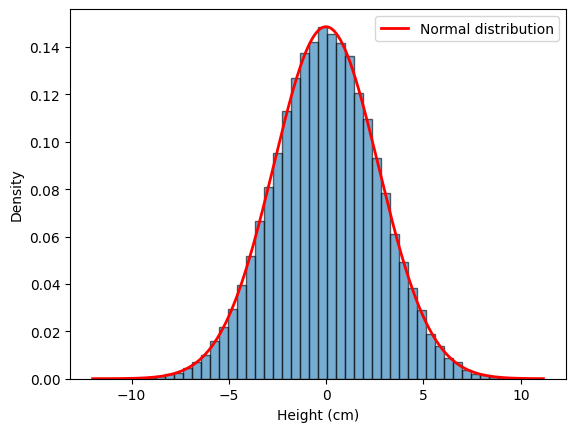

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.hist(heights, bins=50, density=True, alpha=0.6, edgecolor="black")
plt.xlabel("Height (cm)")
plt.ylabel("Density")

# Fit a normal curve (with same mean and std as data)
mu, sigma = np.mean(heights), np.std(heights)
x = np.linspace(min(heights), max(heights), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2, label="Normal distribution")
plt.legend()

plt.show()


Distribution of heights is thus normally distributed. Please note that this conclusion is about the population. Not the sampling distribution of sample means, for which we generally apply CLT for statistical inference problems. In fact, application of CLT for statistical inference (sampling distribution, confidence intervals) is a natural extension of what we saw above. For sampling distribution, we repeatedly take samples from one identical population distribution and then sum or average it. So as per CLT, it would be normally distributed as long as variance is finite.

# Case 2 : Non identical distributions

It is a big assumption that all genetic contributions to human height come from the same distribution. The gene contributing to neck height would have a different distribution when compared to the gene contributing to thigh height.

In [251]:
# 180 different scales
np.random.seed(1)
# scales = np.linspace(0.6, 1, 180)      

# 180 different scales
scales = np.linspace(0.6, 1, 179)       # means from 0.1 to 1.3
scales = np.append(scales, [10])

# Draw one sample from each N(mu_i, sigma_i)
sample = np.array([np.random.exponential(scale=scale) for scale in scales])

print(sample.shape)
sample.sum()

(180,)


144.5978151068236

In [252]:
population = np.array([
    np.random.exponential(scale=scales)  # vectorized draw
    for _ in range(100000)
])
print(population.shape)

(100000, 180)


In [253]:
heights = population.sum(axis=1)

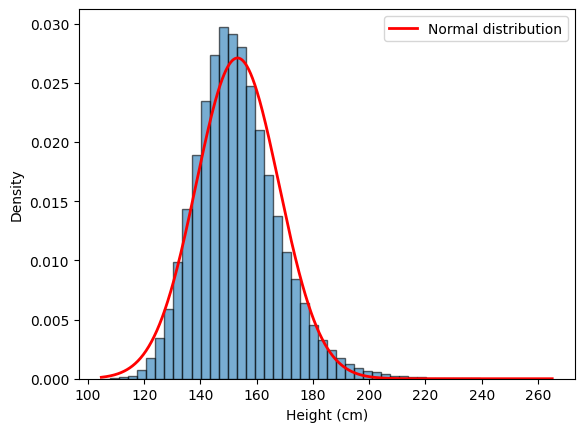

In [254]:
from scipy.stats import norm
plt.hist(heights, bins=50, density=True, alpha=0.6, edgecolor="black")
plt.xlabel("Height (cm)")
plt.ylabel("Density")

# Fit a normal curve (with same mean and std as data)
mu, sigma = np.mean(heights), np.std(heights)
x = np.linspace(min(heights), max(heights), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', linewidth=2, label="Normal distribution")
plt.legend()
plt.show()

In [256]:
n_sims, n_vars = population.shape
# 1. column means mu_i
mu = population.mean(axis=0)            # shape (180,)

# 2. centered values and squared deviations
centered = population - mu              # shape (100000, 180)
sq_dev = centered**2                    # shape (100000, 180)

# 3. empirical variance per column (population variance, ddof=0)
var_per_col = sq_dev.mean(axis=0)       # equal to population.var(axis=0, ddof=0)

# 4. s^2 is sum of these variances
s2 = var_per_col.sum()                  # scalar

# 5. s (std of the sum) if you need it
s = np.sqrt(s2)

# 4. function to compute L(epsilon) empirically
def lindeberg_empirical(eps):
    # indicator matrix: True where |X_ji - mu_i| > eps * s
    indicators = (np.abs(centered) > (eps * s))
    # elementwise product: squared dev * indicator
    contribs = sq_dev * indicators
    # average over rows for each column -> empirical E[(X-mu)^2 1{...}] per i
    means_per_col = contribs.mean(axis=0)    # shape (180,)
    # sum over columns, normalize
    L = np.sum(means_per_col) / s2
    return L

# 5. compute for a set of epsilons
epsilons = [0.25, 0.5, 1.0, 1.5, 2.0,10]
L_values = {eps: lindeberg_empirical(eps) for eps in epsilons}

print("s^2 =", s2, " s =", s)
for eps, L in L_values.items():
    print(f"epsilon={eps:4.2f} -> L(eps) = {L:.6f}")


s^2 = 216.99650128645308  s = 14.730801108101796
epsilon=0.25 -> L(eps) = 0.528542
epsilon=0.50 -> L(eps) = 0.411679
epsilon=1.00 -> L(eps) = 0.278488
epsilon=1.50 -> L(eps) = 0.211720
epsilon=2.00 -> L(eps) = 0.150595
epsilon=10.00 -> L(eps) = 0.000000


In [212]:

def per_column_lindeberg(eps):
    indicators = (np.abs(centered) > (eps * s))    # shape (n_rows, m)
    contribs = sq_dev * indicators                 # shape (n_rows, m)
    # empirical expectation across rows for each column
    means_per_col = contribs.mean(axis=0)          # shape (m,)
    # column's share of the global L: means_per_col / s2
    return means_per_col / s2

eps = 0.25
col_L = per_column_lindeberg(eps)   # array length 180
# total L should match your L(eps)
total_L = col_L.sum()
print("Total L(eps):", total_L)

# show top contributing columns (index, contribution, sigma, mu)
top_k = 10
idx_sorted = np.argsort(col_L)[::-1]
for rank, idx in enumerate(idx_sorted[:top_k], 1):
    print(f"{rank:2d}. col={idx:3d}  L_col={col_L[idx]:.6f}  mu={mus[idx]:.4g}  sigma={sigmas[idx]:.4g}")

# How many rows produce a large deviation in those top columns?
for idx in idx_sorted[:top_k]:
    count = (np.abs(centered[:, idx]) > eps * s).sum()
    print(f"col {idx:3d} large-deviation rows: {count} / {n_rows} ({count/n_rows:.3%})")


Total L(eps): 0.5537432591765797
 1. col=179  L_col=0.484239  mu=1100  sigma=200
 2. col=178  L_col=0.001171  mu=0.1  sigma=0.03
 3. col=177  L_col=0.001109  mu=0.09972  sigma=0.02989
 4. col=175  L_col=0.001094  mu=0.09916  sigma=0.02966
 5. col=176  L_col=0.001085  mu=0.09944  sigma=0.02978
 6. col=172  L_col=0.001045  mu=0.09831  sigma=0.02933
 7. col=170  L_col=0.001042  mu=0.09775  sigma=0.0291
 8. col=173  L_col=0.001033  mu=0.0986  sigma=0.02944
 9. col=167  L_col=0.001019  mu=0.09691  sigma=0.02876
10. col=169  L_col=0.001017  mu=0.09747  sigma=0.02899
col 179 large-deviation rows: 72840 / 1000 (7284.000%)
col 178 large-deviation rows: 1104 / 1000 (110.400%)
col 177 large-deviation rows: 1019 / 1000 (101.900%)
col 175 large-deviation rows: 1025 / 1000 (102.500%)
col 176 large-deviation rows: 1015 / 1000 (101.500%)
col 172 large-deviation rows: 971 / 1000 (97.100%)
col 170 large-deviation rows: 970 / 1000 (97.000%)
col 173 large-deviation rows: 968 / 1000 (96.800%)
col 167 large

max fraction of variance from one column: 0.4612141462830017
top 5 variance fractions: [0.46121415 0.0046524  0.00455848 0.00454949 0.00454192]
179 var_frac: 0.4612141462830017 L_frac: 0.40792505374081656
178 var_frac: 0.004652396777530971 L_frac: 0.00011712229325620485
173 var_frac: 0.0045494865487723975 L_frac: 9.753547780730695e-05
174 var_frac: 0.004533811512198026 L_frac: 8.666351278125479e-05
175 var_frac: 0.004526068173711403 L_frac: 8.660798846951909e-05
171 var_frac: 0.004480648311963636 L_frac: 8.293622649880038e-05
163 var_frac: 0.004291057313857652 L_frac: 7.927043447935194e-05
153 var_frac: 0.004133435574020878 L_frac: 7.610676085184795e-05
168 var_frac: 0.0043604868522208965 L_frac: 7.479926234662721e-05
177 var_frac: 0.004558484102335774 L_frac: 7.383859065979761e-05


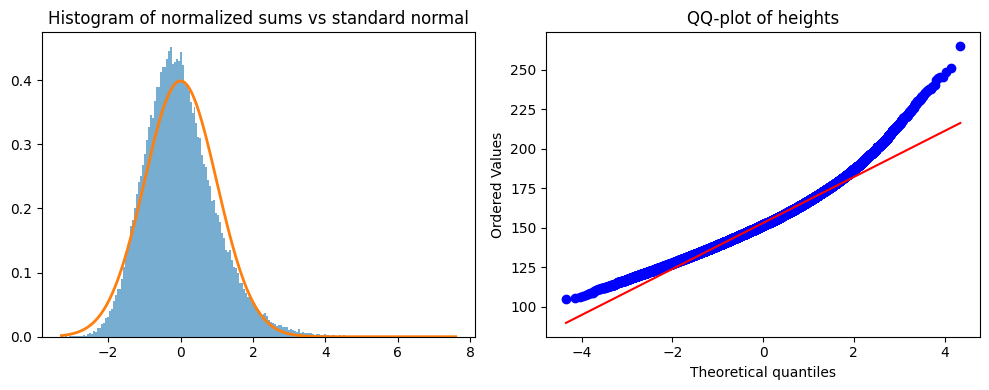

0.25 columns with >0 exceedances: 180 max count: 72223
0.5 columns with >0 exceedances: 138 max count: 40325
1 columns with >0 exceedances: 1 max count: 8464
1.5 columns with >0 exceedances: 1 max count: 4028
2 columns with >0 exceedances: 1 max count: 1967


In [257]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# assuming you already have:
# population: shape (n_sims, n_vars)
# mu, centered, sq_dev, s2, s (as earlier)

n_sims, n_vars = population.shape

# 1) Variance fraction per column
var_per_col = sq_dev.mean(axis=0)             # empirical var per column
frac_var = var_per_col / s2                   # fraction of total variance

# show summary
print("max fraction of variance from one column:", frac_var.max())
print("top 5 variance fractions:", np.sort(frac_var)[-5:][::-1])

# 2) Contribution to L(eps) per column (for one eps)
eps = 0.5
indicators = (np.abs(centered) > (eps * s))
contribs = (sq_dev * indicators).mean(axis=0)  # E[(X-mu)^2 1{...}] for each col
per_col_L_fraction = contribs / s2            # how much each col contributes to L(eps)

# sort and inspect top contributors
order = np.argsort(per_col_L_fraction)[::-1]
for i in order[:10]:
    print(i, "var_frac:", frac_var[i], "L_frac:", per_col_L_fraction[i])

# 3) Plot histogram of sums with normal overlay and a QQ-plot
heights = population.sum(axis=1)
z = (heights - heights.mean()) / heights.std(ddof=0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(z, bins=200, density=True, alpha=0.6)
# normal pdf overlay
xs = np.linspace(z.min(), z.max(), 200)
plt.plot(xs, stats.norm.pdf(xs), linewidth=2)
plt.title("Histogram of normalized sums vs standard normal")

plt.subplot(1,2,2)
stats.probplot(heights, dist="norm", plot=plt)
plt.title("QQ-plot of heights")
plt.tight_layout()
plt.show()

# 4) Inspect tail counts for thresholds
for eps in [0.25,0.5,1,1.5,2]:
    thresh = eps * s
    tail_counts = (np.abs(centered) > thresh).sum(axis=0)  # per column counts
    print(eps, "columns with >0 exceedances:", (tail_counts>0).sum(),
                "max count:", tail_counts.max())
